# MNIST Dataset Investigation

## Imports

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow_datasets import load

## Loading the Dataset

In [2]:
# Loading data
(train_ds, test_ds), ds_info = load('mnist', as_supervised=True, split=['train', 'test'], with_info=True)

## Function to test if a model is better than our saved model

We just use the accuracy on the test dataset for this function for convenience, this should probably be done with a separate dataset.

In [3]:
def save_best_model(model, model_type, test_ds):
    '''
    model is expected to be a newly trained model
    model_type is expected to a string denoting the type of model (i.e. FFNN or CNN)
    '''
    try:
        saved_model = tf.keras.models.load_model(model_type)
    except:
        saved_model = None

    if saved_model:
        saved_model_metrics = saved_model.evaluate(test_ds, return_dict=True)
        new_model_metrics = model.evaluate(test_ds, return_dict=True)
        if new_model_metrics['loss'] < saved_model_metrics['loss']:
            model.save(model_type)
    else:
        model.save(model_type)

## Feed Forward Neural Network

### Processing the Dataset

In [4]:
def normalize_image(image, label):
    return tf.cast(image, tf.float32)/255, label

# Preparing training data
ffnn_train_ds = train_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ffnn_train_ds = ffnn_train_ds.cache()
ffnn_train_ds = ffnn_train_ds.shuffle(ds_info.splits['train'].num_examples)
ffnn_train_ds = ffnn_train_ds.batch(128)
ffnn_train_ds = ffnn_train_ds.prefetch(tf.data.experimental.AUTOTUNE)

# Preparing testing data
ffnn_test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ffnn_test_ds = ffnn_test_ds.cache()
ffnn_test_ds = ffnn_test_ds.batch(128)
ffnn_test_ds = ffnn_test_ds.prefetch(tf.data.experimental.AUTOTUNE)

### Building the Model

In [5]:
ffnn_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28,28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])
ffnn_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [6]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)
ffnn_history = ffnn_model.fit(
    ffnn_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=ffnn_test_ds
)

Epoch 1/100
469/469 [==============================] - 3s 3ms/step - loss: 0.3499 - sparse_categorical_accuracy: 0.9041 - val_loss: 0.1979 - val_sparse_categorical_accuracy: 0.9429
Epoch 2/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1640 - sparse_categorical_accuracy: 0.9528 - val_loss: 0.1377 - val_sparse_categorical_accuracy: 0.9602
Epoch 3/100
469/469 [==============================] - 1s 2ms/step - loss: 0.1183 - sparse_categorical_accuracy: 0.9661 - val_loss: 0.1167 - val_sparse_categorical_accuracy: 0.9653
Epoch 4/100
469/469 [==============================] - 1s 2ms/step - loss: 0.0930 - sparse_categorical_accuracy: 0.9727 - val_loss: 0.1067 - val_sparse_categorical_accuracy: 0.9670
Epoch 5/100
469/469 [==============================] - 1s 2ms/step - loss: 0.0744 - sparse_categorical_accuracy: 0.9778 - val_loss: 0.0887 - val_sparse_categorical_accuracy: 0.9722
Epoch 6/100
469/469 [==============================] - 1s 2ms/step - loss: 0.0615 - sparse_cate

### Plotting the Results

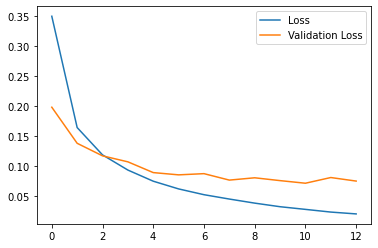

In [14]:
plt.figure()
plt.plot(ffnn_history.history['loss'], label='Loss')
plt.plot(ffnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


### Saving the Best Feed-Forward Model

In [8]:
save_best_model(ffnn_model, 'FFNN', ffnn_test_ds)

79/79 [==============================] - 0s 1ms/step - loss: 0.0746 - sparse_categorical_accuracy: 0.9793


## Convolutional Neural Network

### Processing the Dataset

In [9]:
def cnn_normalize_image(image, label):
    image = tf.cast(image, tf.float32)/255
    image = tf.expand_dims(image, 3) 
    return image, label

# Preparing training data
cnn_train_ds = train_ds.map(cnn_normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
cnn_train_ds = cnn_train_ds.cache()
cnn_train_ds = cnn_train_ds.shuffle(ds_info.splits['train'].num_examples)
cnn_train_ds = cnn_train_ds.batch(128)
cnn_train_ds = cnn_train_ds.prefetch(tf.data.experimental.AUTOTUNE)

# Preparing testing data
cnn_test_ds = test_ds.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = cnn_test_ds.cache()
cnn_test_ds = cnn_test_ds.batch(128)
cnn_test_ds = cnn_test_ds.prefetch(tf.data.experimental.AUTOTUNE)

### Buliding the Model

In [10]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10)
])
cnn_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam()
)

### Training the Model

In [11]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=2)
cnn_history = cnn_model.fit(
    cnn_train_ds,
    callbacks=[early_stopping_callback],
    epochs=100,
    validation_data=cnn_test_ds
)

Epoch 1/100
469/469 [==============================] - 9s 4ms/step - loss: 0.3539 - sparse_categorical_accuracy: 0.9012 - val_loss: 0.1568 - val_sparse_categorical_accuracy: 0.9578
Epoch 2/100
469/469 [==============================] - 2s 3ms/step - loss: 0.1288 - sparse_categorical_accuracy: 0.9644 - val_loss: 0.0955 - val_sparse_categorical_accuracy: 0.9731
Epoch 3/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0880 - sparse_categorical_accuracy: 0.9756 - val_loss: 0.0770 - val_sparse_categorical_accuracy: 0.9754
Epoch 4/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0704 - sparse_categorical_accuracy: 0.9800 - val_loss: 0.0647 - val_sparse_categorical_accuracy: 0.9800
Epoch 5/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0605 - sparse_categorical_accuracy: 0.9828 - val_loss: 0.0606 - val_sparse_categorical_accuracy: 0.9814
Epoch 6/100
469/469 [==============================] - 2s 3ms/step - loss: 0.0530 - sparse_cate

### Plotting the Training Results

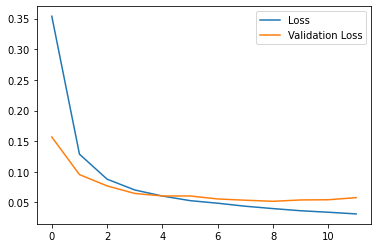

In [13]:
plt.figure()
plt.plot(cnn_history.history['loss'], label='Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

### Saving the Best CNN Model

In [15]:
save_best_model(cnn_model, 'CNN', cnn_test_ds)

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets
